## Benchmarking scVI MLflow Model with czbenchmarks

This notebook demonstrates how to:

- Package a pre-trained scVI model using MLflow
- Use czbenchmarks datasets for evaluation
- Run inference through the MLflow model interface
- Evaluate the model embeddings using czbenchmarks tasks
- Compare results with PCA baselines



### Setup and Model Packaging

In this section, we'll clone the scvi_mlflow_pkg repository, set up the environment, and package the scVI model as an MLflow artifact.

In [ ]:
# Package the VCP mlflow model to run within this notebook.
# -------------------------------------------------------------------
# This script must be run before executing any benchmarking steps below.
# It will:
#   - Package the VCP model as an MLflow artifact
#   - Save the model path to 'mlflow_model_path.txt'
#   - Ensure the model is ready for downstream czbenchmarks evaluation
# -------------------------------------------------------------------
!./package_vcp_model.sh

### Optional: Environment Setup for Notebook

To ensure all dependencies are available, you can create a dedicated Python environment and install all required packages. 


In [ ]:
# # ---------------------------------------------------------------
# # Optional: Create an isolated virtual environment 
# # ---------------------------------------------------------------
# # This step is only needed if you want to ensure full isolation from your base Python environment.
# # Run each command below one at a time (remove the leading '#' to execute).
# # After running, restart your Jupyter kernel and select "Python (.venv_scvi)" as your kernel.

# # 1. Create a new virtual environment (run once)
# !python3 -m venv .venv_scvi

# # 2. Upgrade pip and install required packages
# !.venv_scvi/bin/python -m pip install --upgrade pip
# !.venv_scvi/bin/python -m pip install ipykernel numpy pandas scvi-tools tabulate matplotlib seaborn czbenchmarks anndata mlflow

# # 3. Register the new environment as a Jupyter kernel
# !.venv_scvi/bin/python -m ipykernel install --user --name venv_scvi --display-name "Python (.venv_scvi)"

# print("Virtual environment setup instructions provided. To use, uncomment and run each step above, then restart the kernel and select 'Python (.venv_scvi)'.")

### Dataset Preparation with czbenchmarks

Now we'll load a dataset from czbenchmarks and prepare it for inference with our MLflow-packaged scVI model. We need to ensure the dataset has the required observation columns (batch_keys) and save it in the correct format.

In [ ]:
import os
import subprocess
import sys
import functools
import pandas as pd
import numpy as np
import logging

# Read the MLflow model path from the file created by the bash script
try:
    with open('mlflow_model_path.txt', 'r') as f:
        MLFLOW_MODEL_PATH = f.read().strip()
    print(f"📦 MLflow model path loaded: {MLFLOW_MODEL_PATH}")
except FileNotFoundError:
    print("❌ MLflow model path file not found. Please run the setup bash script first.")
    raise


# Import required libraries
from czbenchmarks.datasets import load_dataset
from czbenchmarks.datasets.single_cell_labeled import SingleCellLabeledDataset
import anndata as ad

# Set up logging
logging.basicConfig(level=logging.INFO, stream=sys.stdout)

print("\n" + "=" * 60)
print("--- Loading and Preparing czbenchmarks Dataset ---")
print("=" * 60)

# Load the dataset
print("🔄 Loading tsv2_prostate dataset...")
dataset: SingleCellLabeledDataset = load_dataset("tsv2_prostate")
print("✅ Dataset loaded successfully")
print(f"📊 Dataset shape: {dataset.adata.shape}")
print(f"🏷️  Labels: {dataset.labels.name} with {len(dataset.labels.unique())} unique values")

# Prepare the dataset for scVI MLflow model
print("\n🔄 Preparing dataset for scVI MLflow model...")

# The MLflow model expects specific batch_keys - let's check what we have
adata = dataset.adata.copy()
print(f"📋 Available observation columns: {list(adata.obs.columns)}")

# Default batch_keys expected by the model
expected_batch_keys = ["dataset_id", "assay", "suspension_type", "donor_id"]

# Check which batch_keys are available and create missing ones
available_batch_keys = []
for key in expected_batch_keys:
    if key in adata.obs.columns:
        available_batch_keys.append(key)
        print(f"✅ Found {key}: {adata.obs[key].nunique()} unique values")
    else:
        # Create a default value for missing batch keys
        adata.obs[key] = f"default_{key}"
        available_batch_keys.append(key)
        print(f"⚠️  Created missing {key} with default value")

# Create batch identifier by combining batch_keys
print(f"🔗 Creating batch identifier from: {available_batch_keys}")
adata.obs["batch"] = functools.reduce(
    lambda a, b: a + b, 
    [adata.obs[c].astype(str) + "_" for c in available_batch_keys]
)

# Remove trailing underscore
adata.obs["batch"] = adata.obs["batch"].str.rstrip("_")

print(f"📦 Created {adata.obs['batch'].nunique()} unique batch identifiers")

# Save the prepared dataset
prepared_data_path = "prepared_dataset.h5ad"
adata.write_h5ad(prepared_data_path)
print(f"💾 Prepared dataset saved to: {os.path.abspath(prepared_data_path)}")

# Store information for next steps
DATASET_PATH = os.path.abspath(prepared_data_path)
BATCH_KEYS_STR = ",".join(available_batch_keys)
ORIGINAL_LABELS = dataset.labels.copy()
ORIGINAL_ADATA_FOR_BASELINE = dataset.adata.copy()  # Keep original for baseline computation

print(f"🎯 Dataset ready for MLflow model inference")
print(f"📁 Dataset path: {DATASET_PATH}")
print(f"🔑 Batch keys: {BATCH_KEYS_STR}")

📦 MLflow model path loaded: /Users/sgupta/cz-benchmarks/examples/vcp-model-pkg-client-tools/examples/mlflow_pkgs/scvi_mlflow_pkg/mlflow_model_artifact

--- Loading and Preparing czbenchmarks Dataset ---
🔄 Loading tsv2_prostate dataset...
INFO:czbenchmarks.file_utils:File already exists in cache: /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad
INFO:czbenchmarks.datasets.single_cell:Loading dataset from /Users/sgupta/.cz-benchmarks/datasets/homo_sapiens_10df7690-6d10-4029-a47e-0f071bb2df83_Prostate_v2_curated.h5ad


... storing 'batch' as categorical


✅ Dataset loaded successfully
📊 Dataset shape: (2044, 21808)
🏷️  Labels: cell_type with 14 unique values

🔄 Preparing dataset for scVI MLflow model...
📋 Available observation columns: ['donor_id', 'tissue_in_publication', 'anatomical_position', 'method', 'cdna_plate', 'library_plate', 'notes', 'cdna_well', 'assay_ontology_term_id', 'sample_id', 'replicate', '10X_run', 'ambient_removal', 'donor_method', 'donor_assay', 'donor_tissue', 'donor_tissue_assay', 'cell_type_ontology_term_id', 'compartment', 'broad_cell_class', 'free_annotation', 'manually_annotated', 'published_2022', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ercc', 'pct_counts_ercc', '_scvi_batch', '_scvi_labels', 'scvi_leiden_donorassay_full', 'ethnicity_original', 'sample_number', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id'

### MLflow Model Inference

In this section, we'll prepare the input for our MLflow-packaged scVI model, run inference, and extract the embeddings. The MLflow model expects input in a specific JSON format with the dataset path and parameters.

In [2]:
import mlflow
import json

print("\n" + "=" * 60)
print("--- Running MLflow Model Inference ---")
print("=" * 60)

# Prepare input for MLflow model
print("🔄 Preparing MLflow model input...")

# Create the input JSON structure expected by the MLflow model
mlflow_input = {
    "dataframe_split": {
        "columns": ["input_uri"],
        "data": [[DATASET_PATH]]
    },
    "params": {
        "organism": "human",
        "return_dist": True,  # Return mean embeddings
        "batch_keys": BATCH_KEYS_STR
    }
}

# Save input to temporary file
input_json_path = "mlflow_input.json"
with open(input_json_path, 'w') as f:
    json.dump(mlflow_input, f, indent=2)

print("✅ MLflow input prepared:")
print(json.dumps(mlflow_input, indent=2))

# Run MLflow model prediction
print(f"\n🔄 Running inference with MLflow model...")
print(f"📦 Model path: {MLFLOW_MODEL_PATH}")
print(f"📄 Input path: {os.path.abspath(input_json_path)}")

try:
    # Use MLflow's predict API
    print("🚀 Starting MLflow model prediction...")
    
    # Load the MLflow model
    loaded_model = mlflow.pyfunc.load_model(MLFLOW_MODEL_PATH)
    
    # Prepare input DataFrame for prediction
    input_df = pd.DataFrame({"input_uri": [DATASET_PATH]})
    
    # Run prediction with parameters
    predictions = loaded_model.predict(
        input_df, 
        params={
            "organism": "human",
            "return_dist": True,
            "batch_keys": BATCH_KEYS_STR
        }
    )
    
    print("✅ MLflow model prediction completed successfully")
    print(f"📊 Predictions shape: {predictions.shape}")
    print(f"📈 Predictions type: {type(predictions)}")
    
    # Convert to numpy array if needed
    if hasattr(predictions, 'values'):
        model_embeddings = predictions.values
    else:
        model_embeddings = np.array(predictions)
    
    print(f"🎯 Generated embeddings shape: {model_embeddings.shape}")
    print(f"📊 Embedding statistics:")
    print(f"   Mean: {model_embeddings.mean():.4f}")
    print(f"   Std: {model_embeddings.std():.4f}")
    print(f"   Min: {model_embeddings.min():.4f}")
    print(f"   Max: {model_embeddings.max():.4f}")
    
    # Save embeddings for later use
    np.save("scvi_mlflow_embeddings.npy", model_embeddings)
    print("💾 Embeddings saved to: scvi_mlflow_embeddings.npy")
    
except Exception as e:
    print(f"❌ Error running MLflow model: {e}")
    print("🔍 Troubleshooting tips:")
    print("   1. Ensure the MLflow model was packaged correctly")
    print("   2. Check that the dataset has required batch_keys columns")
    print("   3. Verify the model artifacts are properly downloaded")
    raise

# Verify embeddings are ready for czbenchmarks tasks
print(f"\n🎯 Embeddings ready for czbenchmarks evaluation!")
print(f"📐 Embedding dimensions: {model_embeddings.shape}")
print(f"🔢 Number of cells: {model_embeddings.shape[0]}")
print(f"📏 Latent dimensions: {model_embeddings.shape[1]}")


--- Running MLflow Model Inference ---
🔄 Preparing MLflow model input...
✅ MLflow input prepared:
{
  "dataframe_split": {
    "columns": [
      "input_uri"
    ],
    "data": [
      [
        "/Users/sgupta/cz-benchmarks/examples/prepared_dataset.h5ad"
      ]
    ]
  },
  "params": {
    "organism": "human",
    "return_dist": true,
    "batch_keys": "dataset_id,assay,suspension_type,donor_id"
  }
}

🔄 Running inference with MLflow model...
📦 Model path: /Users/sgupta/cz-benchmarks/examples/vcp-model-pkg-client-tools/examples/mlflow_pkgs/scvi_mlflow_pkg/mlflow_model_artifact
📄 Input path: /Users/sgupta/cz-benchmarks/examples/mlflow_input.json
🚀 Starting MLflow model prediction...


2025/07/30 12:11:18 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - anndata (current: 0.11.4, required: anndata==0.10.8)
 - databricks-sdk (current: 0.60.0, required: databricks-sdk==0.59.0)
 - flax (current: 0.10.7, required: flax==0.10.4)
 - gitpython (current: 3.1.45, required: gitpython==3.1.44)
 - greenlet (current: uninstalled, required: greenlet==3.2.3)
 - jax (current: 0.6.2, required: jax==0.4.33)
 - jaxlib (current: 0.6.2, required: jaxlib==0.4.33)
 - numpy (current: 2.2.6, required: numpy==1.26.4)
 - opentelemetry-api (current: 1.36.0, required: opentelemetry-api==1.35.0)
 - opentelemetry-sdk (current: 1.36.0, required: opentelemetry-sdk==1.35.0)
 - opentelemetry-semantic-conventions (current: 0.57b0, required: opentelemetry-semantic-conventions==0.56b0)
 - orbax-checkpoint (current: 0.11.19, required: orbax-checkpoint==0.6.4)
 - pandas (current: 2.3.1, required: pandas==2.2.3)
 

INFO     File                                                                                                      
         /Users/sgupta/cz-benchmarks/examples/vcp-model-pkg-client-tools/examples/mlflow_pkgs/scvi_mlflow_pkg/mlflo
         w_model_artifact/artifacts/homo_sapiens/model.pt already downloaded                                       
INFO     Found 44.05% reference vars in query data.                                                                


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/scvi/model/base/_archesmixin.py:299: UserWarning: Query data contains less than 80% of reference var names. This may result in poor performance.
  return _pad_and_sort_query_anndata(adata, var_names, inplace)


INFO     File                                                                                                      
         /Users/sgupta/cz-benchmarks/examples/vcp-model-pkg-client-tools/examples/mlflow_pkgs/scvi_mlflow_pkg/mlflo
         w_model_artifact/artifacts/homo_sapiens/model.pt already downloaded                                       


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/anndata/_core/merge.py:1434: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/scvi/model/base/_archesmixin.py:105: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


✅ MLflow model prediction completed successfully
📊 Predictions shape: (2044, 50)
📈 Predictions type: <class 'numpy.ndarray'>
🎯 Generated embeddings shape: (2044, 50)
📊 Embedding statistics:
   Mean: -0.0598
   Std: 0.6043
   Min: -5.1222
   Max: 5.0177
💾 Embeddings saved to: scvi_mlflow_embeddings.npy

🎯 Embeddings ready for czbenchmarks evaluation!
📐 Embedding dimensions: (2044, 50)
🔢 Number of cells: 2044
📏 Latent dimensions: 50


### czbenchmarks Task Evaluation

Finally, we'll use the embeddings from our MLflow model to run czbenchmarks tasks including clustering, embedding quality assessment, and metadata label prediction. We'll compare the results with PCA baselines and generate visualizations.


--- czbenchmarks Task Evaluation ---
✅ Loaded MLflow model embeddings: (2044, 50)
📊 Expression data shape: (2044, 21808)
🏷️  Labels shape: (2044,)
📋 Number of unique labels: 14

🎯 Task 1: Clustering Performance
🔄 Initializing clustering task...
🚀 Running clustering evaluation on MLflow model embeddings...
📊 Computing PCA baseline...
✅ Clustering evaluation completed
📈 Creating clustering performance visualization...


## Clustering Results

,metric_type,value,params,source,metric_name
0,MetricType.ADJUSTED_RAND_INDEX,0.728258,{},scVI MLflow Model,ADJUSTED_RAND_INDEX
1,MetricType.NORMALIZED_MUTUAL_INFO,0.869382,{},scVI MLflow Model,NORMALIZED_MUTUAL_INFO
0,MetricType.ADJUSTED_RAND_INDEX,0.626707,{},PCA Baseline,ADJUSTED_RAND_INDEX
1,MetricType.NORMALIZED_MUTUAL_INFO,0.832648,{},PCA Baseline,NORMALIZED_MUTUAL_INFO


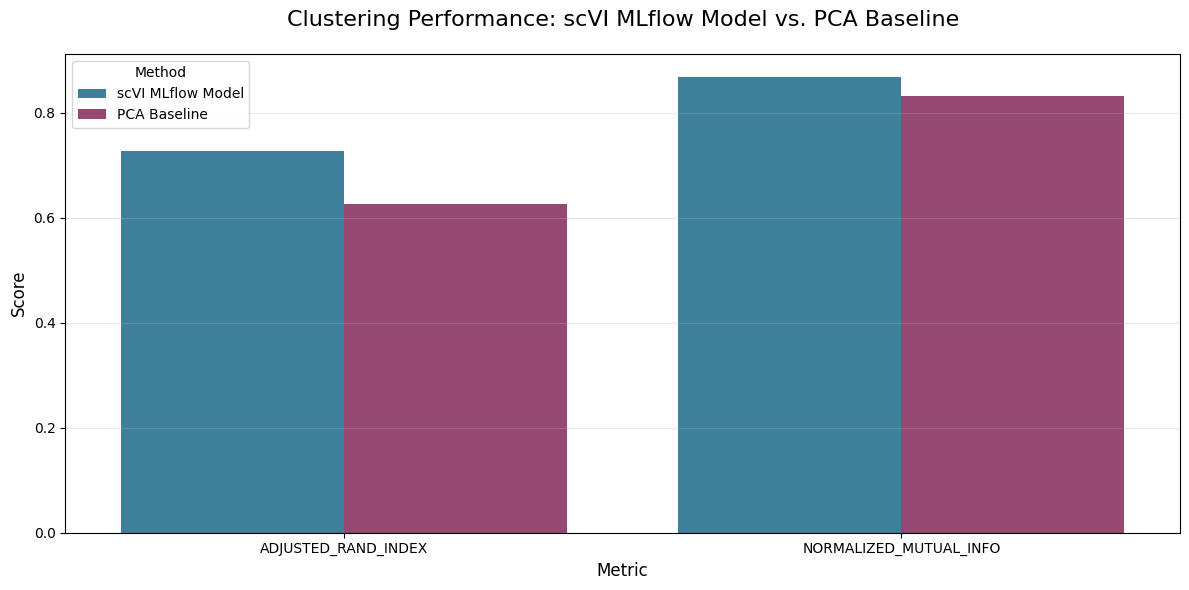


🎯 Task 2: Embedding Quality Assessment
🔄 Initializing embedding quality task...
🚀 Evaluating MLflow model embedding quality...
📊 Computing PCA baseline...
✅ Embedding quality evaluation completed
📈 Creating embedding quality visualization...


## Embedding Quality Results

,metric_type,value,params,source,metric_name
0,MetricType.SILHOUETTE_SCORE,0.627913,{},scVI MLflow Model,SILHOUETTE_SCORE
0,MetricType.SILHOUETTE_SCORE,0.650182,{},PCA Baseline,SILHOUETTE_SCORE


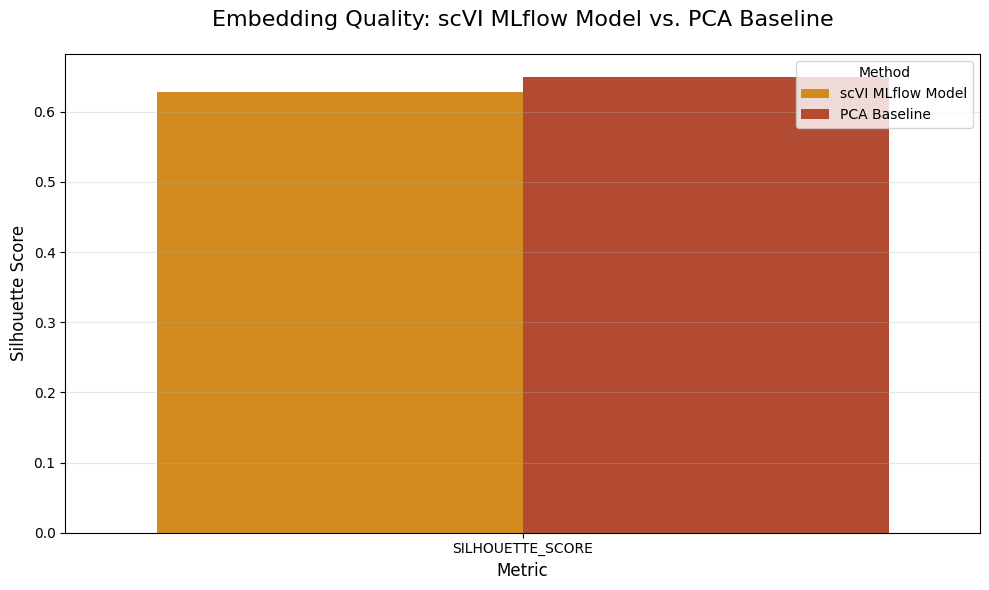


🎯 Task 3: Metadata Label Prediction
🔄 Initializing label prediction task...
🚀 Running label prediction on MLflow model embeddings...
INFO:czbenchmarks.tasks.label_prediction:Starting prediction task for labels
INFO:czbenchmarks.tasks.label_prediction:Initial data shape: (2044, 50), labels shape: (2044,)
INFO:czbenchmarks.tasks.utils:Label composition (cell_type):
INFO:czbenchmarks.tasks.utils:Total classes before filtering: 14
INFO:czbenchmarks.tasks.utils:Total classes after filtering (min_class_size=10): 13
INFO:czbenchmarks.tasks.label_prediction:After filtering: (2043, 50) samples remaining
INFO:czbenchmarks.tasks.label_prediction:Found 13 classes, using macro averaging for metrics
INFO:czbenchmarks.tasks.label_prediction:Using 5-fold cross validation with random_seed 42
INFO:czbenchmarks.tasks.label_prediction:Created classifiers: ['lr', 'knn', 'rf']
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for lr...
INFO:czbenchmarks.tasks.label_prediction:Running cross-

/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

INFO:czbenchmarks.tasks.label_prediction:Completed cross-validation for all classifiers
INFO:czbenchmarks.tasks.label_prediction:Computing final metrics...
📊 Computing PCA baseline...
INFO:czbenchmarks.tasks.label_prediction:Starting prediction task for labels
INFO:czbenchmarks.tasks.label_prediction:Initial data shape: (2044, 21808), labels shape: (2044,)
INFO:czbenchmarks.tasks.utils:Label composition (cell_type):
INFO:czbenchmarks.tasks.utils:Total classes before filtering: 14
INFO:czbenchmarks.tasks.utils:Total classes after filtering (min_class_size=10): 13
INFO:czbenchmarks.tasks.label_prediction:After filtering: (2043, 21808) samples remaining
INFO:czbenchmarks.tasks.label_prediction:Found 13 classes, using macro averaging for metrics
INFO:czbenchmarks.tasks.label_prediction:Using 5-fold cross validation with random_seed 42
INFO:czbenchmarks.tasks.label_prediction:Created classifiers: ['lr', 'knn', 'rf']
INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for lr...

/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for knn...


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _

INFO:czbenchmarks.tasks.label_prediction:Running cross-validation for rf...


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


INFO:czbenchmarks.tasks.label_prediction:Completed cross-validation for all classifiers
INFO:czbenchmarks.tasks.label_prediction:Computing final metrics...
✅ Label prediction evaluation completed
📈 Creating label prediction visualization...


/Users/sgupta/cz-benchmarks/examples/.venv_scvi/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Label Prediction Results (Mean Classifier)

,metric_type,value,params,source,metric_name,classifier
0,MetricType.MEAN_FOLD_ACCURACY,0.958237,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_ACCURACY,"MEAN(knn,lr,rf)"
1,MetricType.MEAN_FOLD_F1_SCORE,0.905656,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_F1_SCORE,"MEAN(knn,lr,rf)"
2,MetricType.MEAN_FOLD_PRECISION,0.914681,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_PRECISION,"MEAN(knn,lr,rf)"
3,MetricType.MEAN_FOLD_RECALL,0.905266,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_RECALL,"MEAN(knn,lr,rf)"
4,MetricType.MEAN_FOLD_AUROC,0.992342,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_AUROC,"MEAN(knn,lr,rf)"
0,MetricType.MEAN_FOLD_ACCURACY,0.793607,"{'classifier': 'MEAN(knn,lr,rf)'}",PCA Baseline,MEAN_FOLD_ACCURACY,"MEAN(knn,lr,rf)"
1,MetricType.MEAN_FOLD_F1_SCORE,0.717191,"{'classifier': 'MEAN(knn,lr,rf)'}",PCA Baseline,MEAN_FOLD_F1_SCORE,"MEAN(knn,lr,rf)"
2,MetricType.MEAN_FOLD_PRECISION,0.808363,"{'classifier': 'MEAN(knn,lr,rf)'}",PCA Baseline,MEAN_FOLD_PRECISION,"MEAN(knn,lr,rf)"
3,MetricType.MEAN_FOLD_RECALL,0.713194,"{'classifier': 'MEAN(knn,lr,rf)'}",PCA Baseline,MEAN_FOLD_RECALL,"MEAN(knn,lr,rf)"
4,MetricType.MEAN_FOLD_AUROC,0.910126,"{'classifier': 'MEAN(knn,lr,rf)'}",PCA Baseline,MEAN_FOLD_AUROC,"MEAN(knn,lr,rf)"


## Label Prediction Results (All Classifiers)

,metric_type,value,params,source,metric_name,classifier
0,MetricType.MEAN_FOLD_ACCURACY,0.958237,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_ACCURACY,"MEAN(knn,lr,rf)"
1,MetricType.MEAN_FOLD_F1_SCORE,0.905656,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_F1_SCORE,"MEAN(knn,lr,rf)"
2,MetricType.MEAN_FOLD_PRECISION,0.914681,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_PRECISION,"MEAN(knn,lr,rf)"
3,MetricType.MEAN_FOLD_RECALL,0.905266,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_RECALL,"MEAN(knn,lr,rf)"
4,MetricType.MEAN_FOLD_AUROC,0.992342,"{'classifier': 'MEAN(knn,lr,rf)'}",scVI MLflow Model,MEAN_FOLD_AUROC,"MEAN(knn,lr,rf)"
5,MetricType.MEAN_FOLD_ACCURACY,0.964759,{'classifier': 'lr'},scVI MLflow Model,MEAN_FOLD_ACCURACY,lr
6,MetricType.MEAN_FOLD_F1_SCORE,0.918456,{'classifier': 'lr'},scVI MLflow Model,MEAN_FOLD_F1_SCORE,lr
7,MetricType.MEAN_FOLD_PRECISION,0.922952,{'classifier': 'lr'},scVI MLflow Model,MEAN_FOLD_PRECISION,lr
8,MetricType.MEAN_FOLD_RECALL,0.919351,{'classifier': 'lr'},scVI MLflow Model,MEAN_FOLD_RECALL,lr
9,MetricType.MEAN_FOLD_AUROC,0.997509,{'classifier': 'lr'},scVI MLflow Model,MEAN_FOLD_AUROC,lr


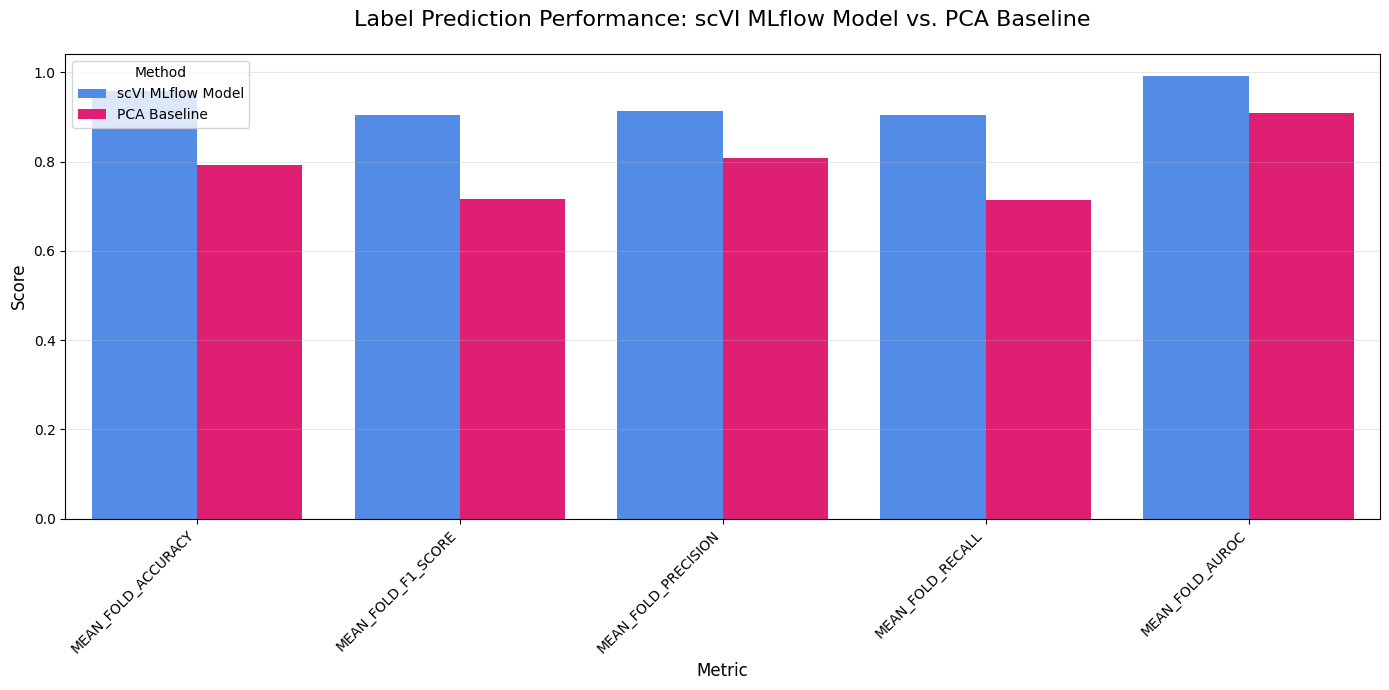

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import scanpy as sc

# Import czbenchmarks tasks
from czbenchmarks.tasks import (
    ClusteringTask,
    EmbeddingTask,
    MetadataLabelPredictionTask,
)
from czbenchmarks.tasks.clustering import ClusteringTaskInput
from czbenchmarks.tasks.embedding import EmbeddingTaskInput
from czbenchmarks.tasks.label_prediction import MetadataLabelPredictionTaskInput
from IPython.display import display, Markdown


print("\n" + "=" * 60)
print("--- czbenchmarks Task Evaluation ---")
print("=" * 60)

# Set up visualization style
sns.set_theme(style="whitegrid")
plt.style.use('default')

# Load embeddings from previous step
try:
    model_embeddings = np.load("scvi_mlflow_embeddings.npy")
    print(f"✅ Loaded MLflow model embeddings: {model_embeddings.shape}")
except:
    print("❌ Could not load embeddings from previous step")
    raise

# Prepare data for tasks
expression_data = ORIGINAL_ADATA_FOR_BASELINE.X
labels = ORIGINAL_LABELS
obs_data = ORIGINAL_ADATA_FOR_BASELINE.obs

print(f"📊 Expression data shape: {expression_data.shape}")
print(f"🏷️  Labels shape: {labels.shape}")
print(f"📋 Number of unique labels: {labels.nunique()}")

# Store all results
all_results = {}

# =============================================================================
# Task 1: Clustering Performance
# =============================================================================
print(f"\n{'='*50}")
print("🎯 Task 1: Clustering Performance")
print(f"{'='*50}")

print("🔄 Initializing clustering task...")
clustering_task = ClusteringTask()
clustering_task_input = ClusteringTaskInput(
    obs=obs_data,
    input_labels=labels,
)

print("🚀 Running clustering evaluation on MLflow model embeddings...")
clustering_results_model = clustering_task.run(
    cell_representation=model_embeddings,
    task_input=clustering_task_input,
)

print("📊 Computing PCA baseline...")
clustering_baseline_embedding = clustering_task.compute_baseline(expression_data)
clustering_results_baseline = clustering_task.run(
    cell_representation=clustering_baseline_embedding,
    task_input=clustering_task_input,
)

# Store results
all_results["clustering"] = {
    "model": [r.model_dump() for r in clustering_results_model],
    "baseline": [r.model_dump() for r in clustering_results_baseline],
}


print("✅ Clustering evaluation completed")

# Visualize clustering results

print("📈 Creating clustering performance visualization...")
df_clustering_model = pd.DataFrame(all_results["clustering"]["model"])
df_clustering_baseline = pd.DataFrame(all_results["clustering"]["baseline"])
df_clustering_model["source"] = "scVI MLflow Model"
df_clustering_baseline["source"] = "PCA Baseline"
df_clustering = pd.concat([df_clustering_model, df_clustering_baseline])
df_clustering["metric_name"] = df_clustering["metric_type"].apply(lambda x: x.name)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_clustering, x="metric_name", y="value", hue="source", 
    palette=["#2E86AB", "#A23B72"]
)
plt.title("Clustering Performance: scVI MLflow Model vs. PCA Baseline", fontsize=16, pad=20)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.legend(title="Method", frameon=True)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
# plt.savefig("clustering_performance_mlflow.png", dpi=300, bbox_inches='tight')
display(Markdown("## Clustering Results"))
display(df_clustering)
plt.show()

# =============================================================================
# Task 2: Embedding Quality
# =============================================================================
print(f"\n{'='*50}")
print("🎯 Task 2: Embedding Quality Assessment")
print(f"{'='*50}")

print("🔄 Initializing embedding quality task...")
embedding_task = EmbeddingTask()
embedding_task_input = EmbeddingTaskInput(input_labels=labels)

print("🚀 Evaluating MLflow model embedding quality...")
embedding_results_model = embedding_task.run(model_embeddings, embedding_task_input)

print("📊 Computing PCA baseline...")
embedding_baseline_embedding = embedding_task.compute_baseline(expression_data)
embedding_results_baseline = embedding_task.run(
    embedding_baseline_embedding, embedding_task_input
)

# Store results
all_results["embedding"] = {
    "model": [r.model_dump() for r in embedding_results_model],
    "baseline": [r.model_dump() for r in embedding_results_baseline],
}

print("✅ Embedding quality evaluation completed")

# Visualize embedding quality results
print("📈 Creating embedding quality visualization...")
df_embedding_model = pd.DataFrame(all_results["embedding"]["model"])
df_embedding_baseline = pd.DataFrame(all_results["embedding"]["baseline"])
df_embedding_model["source"] = "scVI MLflow Model"
df_embedding_baseline["source"] = "PCA Baseline"
df_embedding = pd.concat([df_embedding_model, df_embedding_baseline])
df_embedding["metric_name"] = df_embedding["metric_type"].apply(lambda x: x.name)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_embedding, x="metric_name", y="value", hue="source",
    palette=["#F18F01", "#C73E1D"]
)
plt.title("Embedding Quality: scVI MLflow Model vs. PCA Baseline", fontsize=16, pad=20)
plt.ylabel("Silhouette Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.legend(title="Method", frameon=True)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
# plt.savefig("embedding_quality_mlflow.png", dpi=300, bbox_inches='tight')
display(Markdown("## Embedding Quality Results"))
display(df_embedding)
plt.show()

# =============================================================================
# Task 3: Metadata Label Prediction
# =============================================================================
print(f"\n{'='*50}")
print("🎯 Task 3: Metadata Label Prediction")
print(f"{'='*50}")

print("🔄 Initializing label prediction task...")
prediction_task = MetadataLabelPredictionTask()
prediction_task_input = MetadataLabelPredictionTaskInput(labels=labels)

print("🚀 Running label prediction on MLflow model embeddings...")
prediction_results_model = prediction_task.run(model_embeddings, prediction_task_input)

print("📊 Computing PCA baseline...")
prediction_baseline_embedding = prediction_task.compute_baseline(expression_data)
prediction_results_baseline = prediction_task.run(
    prediction_baseline_embedding, prediction_task_input
)

# Store results
all_results["prediction"] = {
    "model": [r.model_dump() for r in prediction_results_model],
    "baseline": [r.model_dump() for r in prediction_results_baseline],
}

print("✅ Label prediction evaluation completed")

# Visualize prediction results
print("📈 Creating label prediction visualization...")
df_pred_model = pd.DataFrame(all_results["prediction"]["model"])
df_pred_baseline = pd.DataFrame(all_results["prediction"]["baseline"])
df_pred_model["source"] = "scVI MLflow Model"
df_pred_baseline["source"] = "PCA Baseline"
df_pred = pd.concat([df_pred_model, df_pred_baseline])
df_pred["metric_name"] = df_pred["metric_type"].apply(lambda x: x.name)
df_pred["classifier"] = df_pred["params"].apply(lambda p: p.get("classifier", "Overall"))

# Filter for mean metrics for cleaner visualization
df_pred_mean = df_pred[df_pred["classifier"].str.contains("MEAN", na=False)]

plt.figure(figsize=(14, 7))
sns.barplot(
    data=df_pred_mean, x="metric_name", y="value", hue="source",
    palette=["#3A86FF", "#FF006E"]
)
plt.title("Label Prediction Performance: scVI MLflow Model vs. PCA Baseline", fontsize=16, pad=20)
plt.ylabel("Score", fontsize=12)
plt.xlabel("Metric", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Method", frameon=True)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
# plt.savefig("label_prediction_mlflow.png", dpi=300, bbox_inches='tight')
display(Markdown("## Label Prediction Results (Mean Classifier)"))
display(df_pred_mean)

display(Markdown("## Label Prediction Results (All Classifiers)"))
display(df_pred)
plt.show()

